# Define the system  

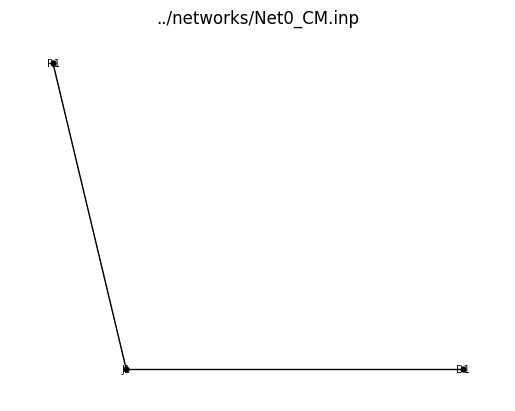

<Axes: title={'center': '../networks/Net0_CM.inp'}>

In [28]:
import wntr
import wntr_quantum

# Create a water network model
inp_file = '../networks/Net0_CM.inp'
# inp_file = '../networks/Net2LoopsCM.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)


## Expression of he network

In [29]:
from wntr_quantum.scenario.network_design_qubo import NetworkDesign
from qubols.solution_vector import SolutionVector_V2 as SolutionVector
from qubols.encodings import  RangedEfficientEncoding, PositiveQbitEncoding

flow_encoding = RangedEfficientEncoding(nqbit=6, range=2, offset=0, var_base_name="x")
head_encoding = RangedEfficientEncoding(nqbit=6, range=2, offset=0, var_base_name="x")


# pipe_diameters = [0.35, 0.4, 0.45, 0.55]
pipe_diameters = [2, 4]
designer = NetworkDesign(wn, flow_encoding=flow_encoding, 
                         head_encoding=head_encoding, 
                         pipe_diameters=pipe_diameters,
                         weight_cost=0)

In [30]:
designer.matrices[0]

array([[0.5],
       [1. ],
       [2. ],
       [0. ],
       [0. ]])

In [31]:
designer.enumerates_classical_solutions()

(0.25, 0.25) [1.5   1.    1.438 1.188]
(0.25, 0.5) [1.5   1.    1.438 0.938]
(0.5, 0.25) [1.5   1.    0.875 0.625]
(0.5, 0.5) [1.5   1.    0.875 0.375]


In [32]:
designer.sol_vect_res.encoded_reals[0].get_possible_values()

[0.24999999999999992, 0.5]

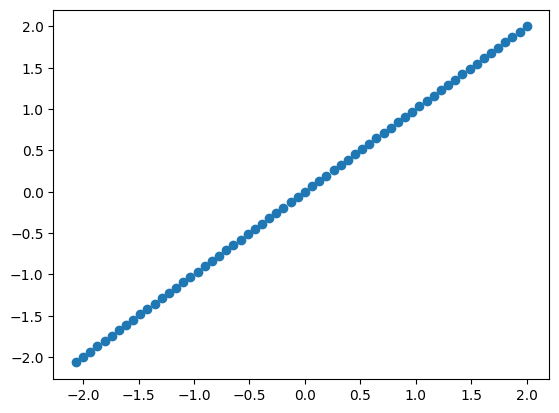

In [33]:
val = designer.sol_vect_flows.encoded_reals[0].get_possible_values()
import matplotlib.pyplot as plt 
plt.scatter(val, val)

In [34]:
from qubols.qubo_poly_mixed_variables import QUBO_POLY_MIXED
import sparse
qubo = QUBO_POLY_MIXED(designer.mixed_solution_vector)

In [35]:
matrices = tuple(sparse.COO(m) for m in designer.matrices)
bqm = qubo.create_bqm(matrices, strength=1000)

In [36]:
istart = designer.sol_vect_flows.size
for i in range(designer.sol_vect_heads.size):

    bqm.add_linear_inequality_constraint(
        qubo.all_expr[istart + i],
        lagrange_multiplier=1,
        label="head_%s" % i,
        lb=1,
        ub=2,
    )

In [50]:
sampleset = qubo.sample_bqm(bqm, num_reads=10000)

In [51]:
flow, heads, param = qubo.decode_solution(sampleset.lowest())

In [52]:
flow, heads, param

([1.4838709677419355, 0.967741935483871],
 [1.032258064516129, 0.9032258064516129],
 [0.5, 0.24999999999999992])

In [53]:
import numpy as np
num_heads = designer.wn.num_junctions
designer.verify_solution(np.array(flow+heads), param)

array([-0.016,  0.032, -0.133, -0.105])

In [54]:
sampleset.record[0]

([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0], -0.628, 1)

In [55]:
nsol = []
cost = []
cons = []
colors = []
for i in range(10000):
    flow, heads, param = qubo.decode_solution(sampleset, sol_index=i)
    nsol.append(np.linalg.norm(designer.verify_solution(np.array(flow+heads), param)))
    cost.append(np.sum(param))
    cons.append(np.sum(np.array(heads)-1))



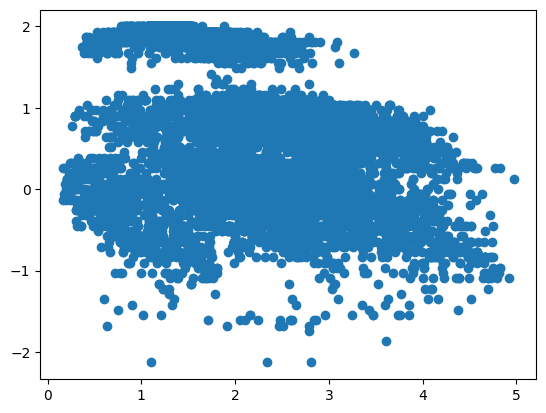

In [56]:
import matplotlib.pyplot as plt
plt.scatter(nsol, cons)